In [1]:
import numpy as np
from matplotlib import pyplot as plt
import reciprocalspaceship as rs
import gemmi as gm
import os
import pandas as pd
import glob

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)

cbrewer1="#1b9e77"
cbrewer2="#d95f02"
cbrewer3="#7570b3"

In this `jupyter` notebook, we assess the quality of the merging as a function of the double-Wilson `r` value. This notebook follows from `Inspect_Careless_param_grid.ipynb`. We do this by computing difference maps from the merged data, as well as a reference difference maps, then compute their real-space cross-correlation. 

We start with two pairs of structure factors: 
- merged structure factors from the 2ms MTZ files output by `careless` ($F_\text{obs,2ms}$)
- the same from the OFF MTZ files ($F_\text{obs,OFF}$)
- structure factors calculated from a model of PYP after 2ms irradiation ($F_\text{calc,2ms}$)
- the same from an OFF model ($F_\text{calc,OFF}$)

We produce an observed difference map from ($F_\text{obs,2ms}$) minus ($F_\text{obs,OFF}$), as well as a reference difference map from ($F_\text{calc,2ms}$) minus ($F_\text{calc,OFF}$). AFter Fourier transformation, of the structure factor differences, we compute the real-space correlation between these two difference maps, both inside and outside a 10 Å region around the active site chromophore. A higher real-space correlation indicates better scaling and merging.  



### Read in difference map and initial processing

First, we read in $F_\text{obs,2ms}$ and $F_\text{obs,OFF}$ from `Inspect_Careless_param_grid.ipynb`. We compute weighted and unweighted differences and then Fourier transform the differences to get a map. 

In [2]:
diffmap_dir_1="./merged_mtzs/"
diffmap="merge_21040353_6414_poly_mc1_50k_cl3_grid_16_2PHY_ref34.mtz"
ds_diff=rs.read_mtz(diffmap_dir_1+diffmap)


In [3]:
try:
    ds_diff["DF"]=ds_diff["DeltaF"]
except:
    print("Field not found")

try:
    tmp=(ds_diff.dtypes=="Phase")
    tmp=tmp.index[tmp==True].to_list()[0]
    ds_diff["Phi"]=ds_diff[tmp]
except:
    print("No phase column found")

try:
    
    tmp=(ds_diff.dtypes=="Weight")
    print(tmp.index[tmp==True].to_list())
    tmp=tmp.index[tmp==True].to_list()[0] # also try 1,2,...
    print(tmp)
    ds_diff["W"]=ds_diff[tmp]
except:
    print("No weight column found")

['W_dh', 'W_dh_b', 'W_dh_c', 'W_dh_d', 'W_dh_e']
W_dh


In [4]:
ds_diff["WDF"]=ds_diff["W"]*ds_diff["DF"]

ds_diff.dropna(inplace=True)
ds_diff["sf_DF"]  = ds_diff.to_structurefactor("DF",  "Phi")
ds_diff["sf_WDF"] = ds_diff.to_structurefactor("WDF", "Phi")
# ds_diff.head()

In [5]:
gridsize=(128,128,64)
rg_DF  = ds_diff.to_reciprocal_grid("sf_DF",  grid_size=gridsize)
rg_WDF = ds_diff.to_reciprocal_grid("sf_WDF", grid_size=gridsize)
map_DF = np.real(np.fft.fftn(rg_DF))
map_WDF= np.real(np.fft.fftn(rg_WDF))

### Read in Fc's 

Next, we read in $F_\text{calc,2ms}$ and $F_\text{calc,OFF}$. The Fc maps were generated with the following procedure: 
1. perform molecular replacement of the ON model (if it has an alternative origin, eg 1TS0) relative to OFF data
2. we set occupancy to 1 (selection: "all") in pymol
3. we find the common origin (use 2PHY as fixed for all; use SSM option and move HETATM option) in pymol
4. then, we compute Fmodel using Phenix. 

Starting from the outputs of this procedure, we compute below the unweighted differences and then Fourier transform the differences to get a reference difference map. Such datasets are provided below for your convenience. 

In [6]:
FC_off=rs.read_mtz("ref/MinMLAD_2phy_1TS0_A_post_MT_occ_1_fmodel.mtz")
FC_on =rs.read_mtz("ref/MinMLAD_2phy_1TS0_B_post_MT_occ_1_fmodel.mtz")

In [7]:
# in this case, this works smoothly because the two models came from the same PDB file with identical uc.
# Otherwise, this may require some jujitsu with pandas dataframes
ds_FcFc = FC_off.copy()
ds_FcFc["sf_FC_off"] = FC_off.to_structurefactor("FMODEL", "PHIFMODEL")
ds_FcFc["sf_FC_on"]  = FC_on.to_structurefactor( "FMODEL", "PHIFMODEL")
rg_Fc_off = ds_FcFc.to_reciprocal_grid("sf_FC_off", grid_size=gridsize)
rg_Fc_on  = ds_FcFc.to_reciprocal_grid("sf_FC_on",  grid_size=gridsize)

In [8]:
map_Fc_off = np.real(np.fft.fftn(rg_Fc_off))
map_Fc_on  = np.real(np.fft.fftn(rg_Fc_on))

### Define a mask for the region of interest

Next, we use `gemmi` to make a mask for the region 10 Å around the active site chromophore, for all copies of PYP in the unit cell. 

In [9]:
model = gm.read_structure("/n/home12/dhekstra/PYP/2phy.pdb")
print(model.cell)
print(model[0][0][125])
print(model[0][0][125][-1])

<gemmi.UnitCell(66.9, 66.9, 40.8, 90, 90, 120)>
126(HC4)
<gemmi.Atom O4' at (17.9, -1.6, -17.2)>


In [10]:
gm_map_WDF = gm.FloatGrid(map_WDF.astype(np.float32))
gm_map_WDF.set_unit_cell(model.cell)
gm_map_WDF.spacegroup=gm.SpaceGroup('P63')

In [11]:
gr = gm_map_WDF.clone()
gr.fill(0)

HC4=model[0][0][125][-1]
HC4_points=[]
ops = gr.spacegroup.operations()
print("Equivalent locations of POI (fractional):")
for op in ops:
    HC4_mapped=op.apply_to_xyz(model.cell.fractionalize(HC4.pos).tolist())
#     print(f"xyz: {HC4_mapped[0]:.3}, {HC4_mapped[1]:.3}, {HC4_mapped[2]:.3} ") 

    tmp = HC4_mapped-np.floor(np.array(HC4_mapped))
    HC4_mapped = gm.Fractional(*tmp)
    print(f"xyz: {HC4_mapped[0]:.3}, {HC4_mapped[1]:.3}, {HC4_mapped[2]:.3} ") 

    HC4_points.append(HC4_mapped)
# print(HC4_points)

Equivalent locations of POI (fractional):
xyz: 0.255, 0.973, 0.579 
xyz: 0.282, 0.255, 0.0785 
xyz: 0.0273, 0.282, 0.579 
xyz: 0.745, 0.0273, 0.0785 
xyz: 0.718, 0.745, 0.579 
xyz: 0.973, 0.718, 0.0785 


In [12]:
radius=10.0
print("Orthogonalized coordinates of POIs (A):")
for pos in HC4_points:
    print(model.cell.orthogonalize(pos))
    gr.set_points_around(model.cell.orthogonalize(pos), radius=radius, value=1)
print(gr.sum())
print(f"Fraction of all voxels within ROI: {100*gr.sum()/np.prod(np.array(gr).shape):.4}%")

Orthogonalized coordinates of POIs (A):
<gemmi.Position(-15.511, 56.3581, 23.603)>
<gemmi.Position(10.337, 14.7461, 3.203)>
<gemmi.Position(-7.60205, 16.3251, 23.603)>
<gemmi.Position(48.961, 1.579, 3.203)>
<gemmi.Position(23.113, 43.191, 23.603)>
<gemmi.Position(41.052, 41.612, 3.203)>
166662.0
Fraction of all voxels within ROI: 15.89%


### Map correlation calculations

Finally, we compute the correlation between the observed and calculated differences.

In [13]:
DFC=(map_Fc_on-map_Fc_off).flatten()
DFO=map_DF.flatten()
WDFO=map_WDF.flatten()
keep=(np.array(gr)==1).flatten()

In [14]:
# plt.plot(WDFO)

In [15]:
print("Unweighted difference map:")
print(f"Real-space CC overall         : {np.corrcoef(DFO,       DFC)[0][1]:.4}")
print(f"Real-space CC within     {radius:.3}A: {np.corrcoef(DFO[keep], DFC[keep])[0][1]:.4}")
print(f"Real-space CC outside of {radius:.3}A: {np.corrcoef(DFO[~keep],DFC[~keep])[0][1]:.4}")

print("")

print("Weighted difference map:")
print(f"Real-space CC overall         : {np.corrcoef(WDFO,       DFC)[0][1]:.4}")
print(f"Real-space CC within     {radius:.3}A: {np.corrcoef(WDFO[keep], DFC[keep])[0][1]:.4}")
print(f"Real-space CC outside of {radius:.3}A: {np.corrcoef(WDFO[~keep],DFC[~keep])[0][1]:.4}")

print(f"{np.corrcoef(DFO, DFC)[0][1]:.4} \
{np.corrcoef(DFO[keep], DFC[keep])[0][1]:.4} \
{np.corrcoef(DFO[~keep],DFC[~keep])[0][1]:.4} \
{np.corrcoef(WDFO, DFC)[0][1]:.4} \
{np.corrcoef(WDFO[keep], DFC[keep])[0][1]:.4} \
{np.corrcoef(WDFO[~keep],DFC[~keep])[0][1]:.4}")

Unweighted difference map:
Real-space CC overall         : 0.1226
Real-space CC within     10.0A: 0.2493
Real-space CC outside of 10.0A: 0.06649

Weighted difference map:
Real-space CC overall         : 0.2442
Real-space CC within     10.0A: 0.4412
Real-space CC outside of 10.0A: 0.1244
0.1226 0.2493 0.06649 0.2442 0.4412 0.1244


# Repeat for all datasets

We repeat this procedure for all datasets output from `careless`, and for all the weighting schemes presented in `Inspect_Careless_param_grid.ipynb`. 

In [16]:
def compute_CCs(diffmap_name, keep=keep, DFC=DFC, weights_column="W_dh"):
    ds_diff=rs.read_mtz(diffmap_name)
    
    try:
        ds_diff["DF"]=ds_diff["DeltaF"]
    except:
        print("Field not found")

    try:
        tmp=(ds_diff.dtypes=="Phase")
        tmp=tmp.index[tmp==True].to_list()[0]
        ds_diff["Phi"]=ds_diff[tmp]
    except:
        print("No phase column found")
        
    ds_diff["WDF"]=ds_diff[weights_column]*ds_diff["DF"]
    ds_diff.dropna(inplace=True)
    ds_diff["sf_DF"]  = ds_diff.to_structurefactor("DF",  "Phi")
    ds_diff["sf_WDF"] = ds_diff.to_structurefactor("WDF", "Phi")
    # ds_diff.head()

    gridsize=(128,128,64)
    rg_DF  = ds_diff.to_reciprocal_grid("sf_DF",  grid_size=gridsize)
    rg_WDF = ds_diff.to_reciprocal_grid("sf_WDF", grid_size=gridsize)
    map_DF = np.real(np.fft.fftn(rg_DF))
    map_WDF= np.real(np.fft.fftn(rg_WDF))
    DFO=map_DF.flatten()
    WDFO=map_WDF.flatten()
    
    return [np.corrcoef(DFO, DFC)[0][1], 
    np.corrcoef(DFO[keep], DFC[keep])[0][1],
    np.corrcoef(DFO[~keep],DFC[~keep])[0][1],
    np.corrcoef(WDFO, DFC)[0][1], 
    np.corrcoef(WDFO[keep], DFC[keep])[0][1],
    np.corrcoef(WDFO[~keep],DFC[~keep])[0][1]]

In [17]:
all_results = pd.read_csv("careless_runs/all_results.csv")
all_results_test_0 = all_results.copy()
for ind,row in all_results_test_0.iterrows():
    for weight in ['W_dh', 'W_dh_b', 'W_dh_c', 'W_dh_d', 'W_dh_e']:
        mtz_str = glob.glob(f"merged_mtzs/merge_210*_poly_mc1_50k_cl3_grid_{row.grid_id}_2PHY_ref34.mtz")[0]
        out = compute_CCs(mtz_str, weights_column = weight)
        all_results_test_0.loc[ind, "DF_CC_overall"]=out[0]
        all_results_test_0.loc[ind, "DF_CC_keep"]=out[1]
        all_results_test_0.loc[ind, "DF_CC_notkeep"]=out[2]
        all_results_test_0.loc[ind, f"WDF_CC_overall_{weight}"]=out[3]
        all_results_test_0.loc[ind, f"WDF_CC_keep_{weight}"]=out[4]
        all_results_test_0.loc[ind, f"WDF_CC_notkeep_{weight}"]=out[5]

all_results_test_0.sort_values(by="rDW",inplace=True)

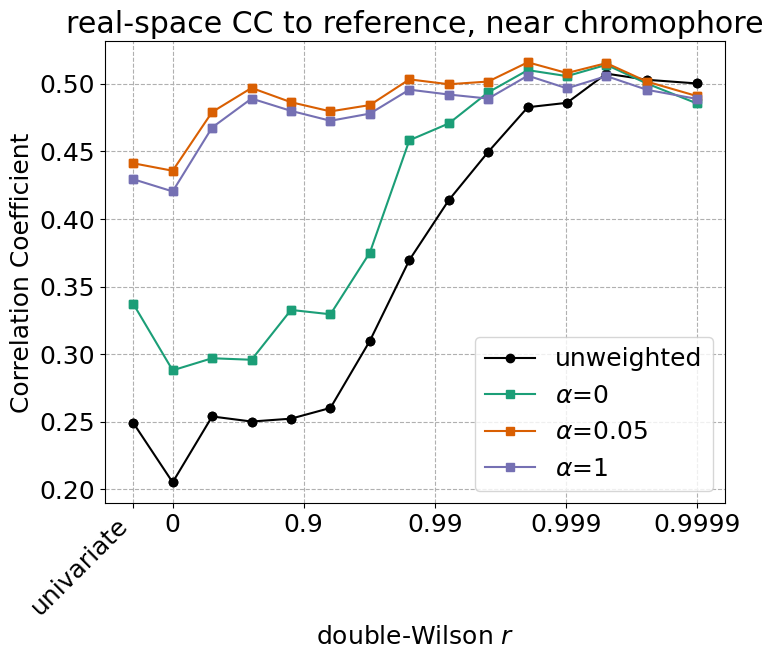

In [18]:
weighted_plot=True #This parameter can be used to make two plots.

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
         all_results_test_0.loc[:,"DF_CC_keep"],'ko-',label="unweighted")

if weighted_plot: 
    plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
             all_results_test_0.loc[:,"WDF_CC_keep_W_dh_d"],'s-',color=cbrewer1,label=r"$\alpha$=0")
plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
         all_results_test_0.loc[:,"WDF_CC_keep_W_dh"],'s-',color=cbrewer2,label=r"$\alpha$=0.05")
if weighted_plot:
    plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
             all_results_test_0.loc[:,"WDF_CC_keep_W_dh_e"],'s-',color=cbrewer3,label=r"$\alpha$=1")
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation Coefficient")
plt.title("real-space CC to reference, near chromophore")
plt.gca().invert_xaxis()
plt.grid(linestyle='--')
plt.legend()
#plt.tight_layout()
plt.savefig(f"figures/real-space CC{'_alphas' if weighted_plot else ''}.svg",bbox_inches="tight")

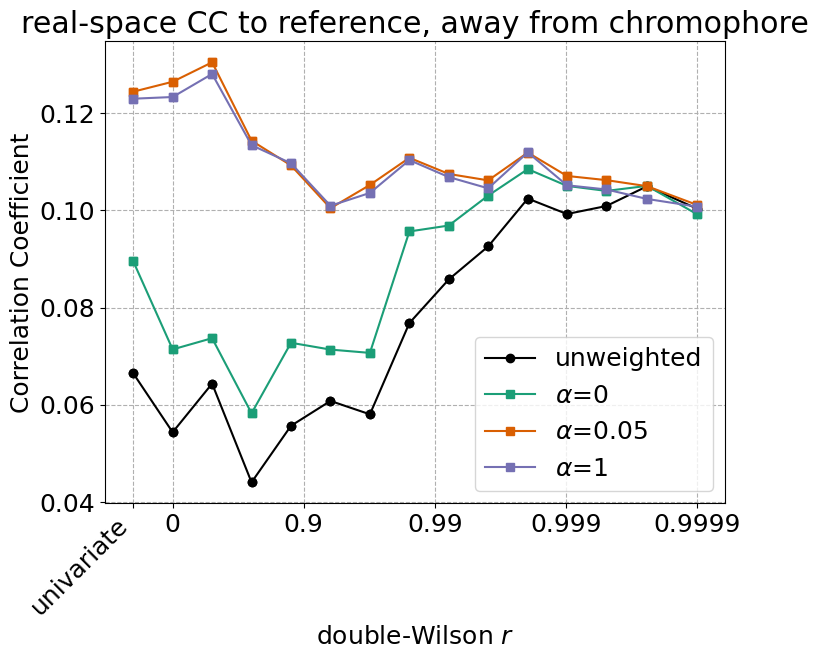

In [19]:
weighted_plot=True #This parameter can be used to make two plots.

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
         all_results_test_0.loc[:,"DF_CC_notkeep"],'ko-',label="unweighted")

if weighted_plot: 
    plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
             all_results_test_0.loc[:,"WDF_CC_notkeep_W_dh_d"],'s-',color=cbrewer1,label=r"$\alpha$=0")
plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
         all_results_test_0.loc[:,"WDF_CC_notkeep_W_dh"],'s-',color=cbrewer2,label=r"$\alpha$=0.05")
if weighted_plot:
    plt.plot(np.log10(1-all_results_test_0.loc[:,"rDW"]),\
             all_results_test_0.loc[:,"WDF_CC_notkeep_W_dh_e"],'s-',color=cbrewer3,label=r"$\alpha$=1")
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation Coefficient")
plt.title("real-space CC to reference, away from chromophore")
plt.gca().invert_xaxis()
plt.grid(linestyle='--')
plt.legend()
#plt.tight_layout()
plt.savefig(f"figures/real-space CC{'_alphas' if weighted_plot else ''}-far.svg",bbox_inches="tight")

we modify the best MTZ files for plotting in pymol. `out_weighted.mtz` contains the unweighted differences with the best real-space CC. `out_univariate.mtz` is the unweighted differences from univariate `careless` merging.

In [20]:
out = rs.read_mtz("merged_mtzs/merge_21040538_19944_poly_mc1_50k_cl3_grid_13_2PHY_ref34.mtz")
out.write_mtz("pymol/out_unweighted.mtz")

out1 = rs.read_mtz("merged_mtzs/merge_21040452_13926_poly_mc1_50k_cl3_grid_11_2PHY_ref34.mtz")
out1["wDF"]=out1["DeltaF"]*out1["W_dh"]
out1.write_mtz("pymol/out_weighted.mtz")

out2 = rs.read_mtz("merged_mtzs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16_2PHY_ref34.mtz")
out2["wDF"]=out2["DeltaF"]*out2["W_dh"]
out2.write_mtz("pymol/out_univariate.mtz")